# Heteroscedastic Regression

## Updated on 27th November 2015

### by Ricardo Andrade

In this Ipython Notebook we will look at how to implement a GP regression with different noise terms using GPy.

$\bf N.B.:$ There is currently no implementation to predict the noise for outputs that are not part of the training set.

Usually, a GP regression model assumes that a set of targets $\{ y_1,\ldots,y_n \}$ is related to a set of inputs $\{ {\bf x }_1,\ldots, {\bf x }_n \}$ through the relation:
$$ y_i = f({\bf x}_i) + \epsilon_i, $$
where $f \sim \mathcal{GP}$ and $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ for all $i$.. An heteroscedastic model works in the same way, but allows different variances for the noise terms of the observations, i.e., $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$. By adding this assumption, the model will now give different weights to each observation. Hence, it will try to fit better those observations with smaller noise and will be free not to fit very well those observations with larger noise.

Before using GPy, we need to perform some setup.

In [1]:
import numpy as np
import pylab as pb
import GPy 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


As an example we will use the following function, which has a peak around 0.

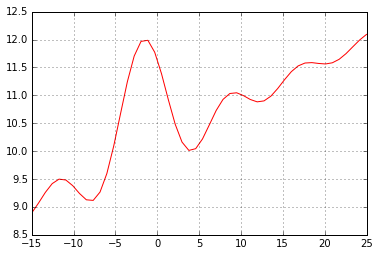

In [2]:
def f(X):
    return 10. + .1*X + 2*np.sin(X)/X

fig,ax = pb.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')
ax.grid()

We will draw some points $( {\bf x},y)$ from the function above, and add some noise on $y$.

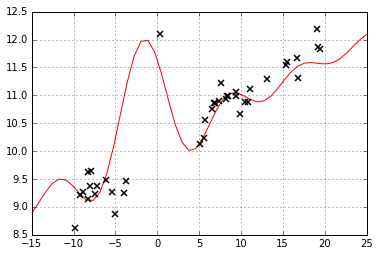

In [3]:
X = np.random.uniform(-10,20, 50)
X = X[~np.logical_and(X>-2,X<3)] #Remove points between -2 and 3 (just for illustration) 
X = np.hstack([np.random.uniform(-1,1,1),X]) #Prepend a point between -1 and 1  (just for illustration)
error = np.random.normal(0,.2,X.size)
Y = f(X) + error
fig,ax = pb.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')
ax.plot(X,Y,'kx',mew=1.5)
ax.grid()

We will use a combination of an MLP and Bias kernels. Although other kernels can be used as well.

In [4]:
kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)

For the moment, we will assume that we already know the error on each observation.
To call the model we just need to run these lines.

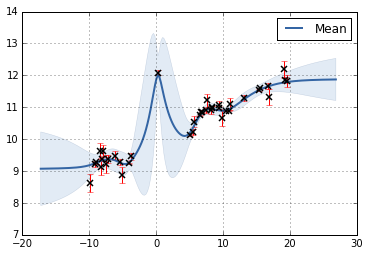

In [11]:
m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m['.*het_Gauss.variance'] = abs(error)[:,None] #Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
m.optimize()

m.plot_f() #Show the predictive values of the GP.
pb.errorbar(X,Y,yerr=np.array(m.likelihood.flattened_parameters).flatten(),fmt=None,ecolor='r',zorder=1)
pb.grid()
pb.plot(X,Y,'kx',mew=1.5)

In the following example we show how the magnitud of the noise of a specific observation modifines the model fit.

In [12]:
def noise_effect(noise):
    m.het_Gauss.variance[:1] = noise
    m.het_Gauss.variance.fix()
    m.optimize()
 
    m.plot_f() 
    pb.errorbar(X.flatten(),Y.flatten(),yerr=np.array(m.likelihood.flattened_parameters).flatten(),fmt=None,ecolor='r',zorder=1)        
    pb.plot(X[1:],Y[1:],'kx',mew=1.5)
    pb.plot(X[:1],Y[:1],'ko',mew=.5)
    pb.grid()

Scroll the bar to see how the GP fitted changes.

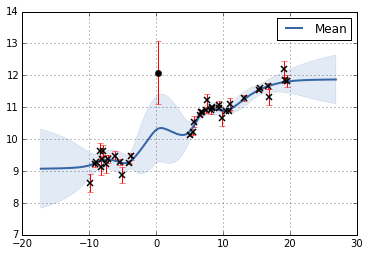

In [13]:
from IPython.html.widgets import *
interact(noise_effect, noise=(0.1,2.))

If we set all the noise terms to be equal, then we have just a homoscedastic GP regression model. The code below shows a comparison between the heteroscedastic and the homoscedastic models when the noise terms are fixed to the same value.

Kernel parameters (optimized) in the heteroscedastic model
  sum.                 |          value  |  constraints  |  priors
  mlp.variance         |  4.89967801037  |      +ve      |        
  mlp.weight_variance  |  7.75023324963  |      +ve      |        
  mlp.bias_variance    |  34.1918051698  |      +ve      |        
  bias.variance        |  106.518086568  |      +ve      |        

Kernel parameters (optimized) in the homoscedastic model
  sum.                 |          value  |  constraints  |  priors
  mlp.variance         |  4.89967801037  |      +ve      |        
  mlp.weight_variance  |  7.75023324963  |      +ve      |        
  mlp.bias_variance    |  34.1918051698  |      +ve      |        
  bias.variance        |  106.518086568  |      +ve      |        


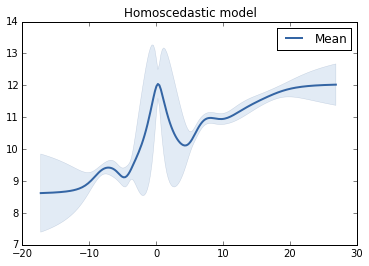

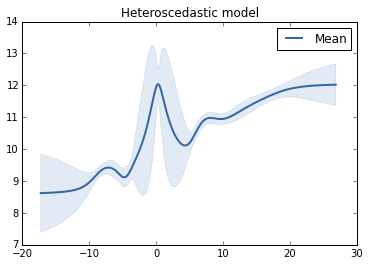

In [14]:
#Heteroscedastic model
m1 = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m1.het_Gauss.variance = .05
m1.het_Gauss.variance.fix()
m1.optimize()

# Homoscedastic model
m2 = GPy.models.GPRegression(X[:,None],Y[:,None],kern)
m2['.*Gaussian_noise'] = .05
m2['.*noise'].fix()
m2.optimize()

m1.plot_f()
pb.title('Homoscedastic model')
m2.plot_f()
pb.title('Heteroscedastic model')

print "Kernel parameters (optimized) in the heteroscedastic model"
print m1.kern
print "\nKernel parameters (optimized) in the homoscedastic model"
print m2.kern

We can also learn the noise for each observation. 
In this case I found useful to set a lower bound on the noise terms of $10^{-6}$ or to add a white noise kenel.
In this case, I found useful to add a white noise kernel.

In [15]:
kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)

In [31]:
m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m.optimize()

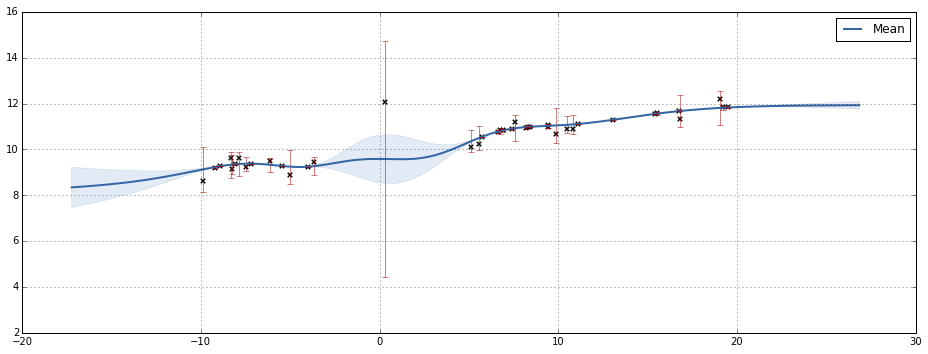

In [36]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
m.plot_f(ax=ax)
m.plot_data(ax=ax)
m.plot_errorbars_trainset(ax=ax, alpha=1)
fig.tight_layout()
pb.grid()

Predictions of $y$ at new points $\bf x$ would need a estimate of the noise term, however we just have those for the training set. At the moment we don't have a rotine to estimate heteroscedastic noise at new points. Estimates for the GP at new poinst are still available using the following command:

In [34]:
mu, var = m._raw_predict(m.X)

### plot density
The new GPy release allows us to plot the density of the GP more fine-grained. This is shown below:

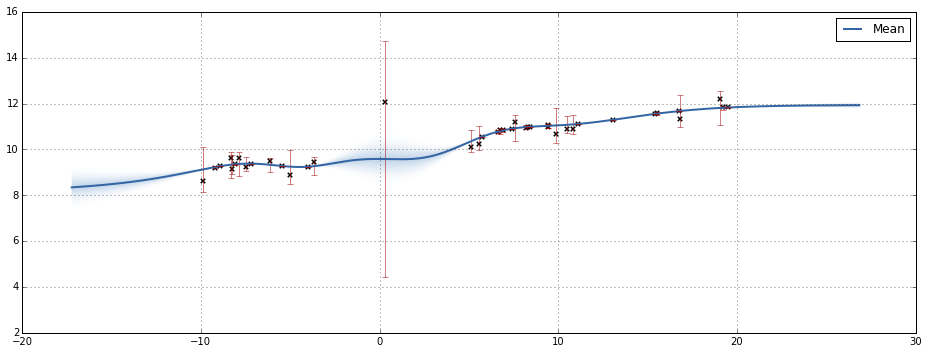

In [37]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
m.plot_f(ax=ax, plot_density=True)
m.plot_data(ax=ax)
m.plot_errorbars_trainset(ax=ax, alpha=1)
fig.tight_layout()
pb.grid()